In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/control`


In [941]:
using ModelingToolkit, DifferentialEquations
using GLMakie
using ForwardDiff

## Plant

In [1199]:
@variables t
D = Differential(t)

# first order system

function Plant(;name)
    sts = @variables (x(t))[1:2, 1:1]=0 (y(t))[1:2]=0 u(t)=0

    A = [0 1; 0 0];
    B = [0;1];
    
    eqn1 = D.(x) ~ A*x + B*u

    eqn2 = y .~ x
    
    eqns = vcat(eqn1, eqn2)
    
    ODESystem(eqns, t; name)
end

Plant (generic function with 1 method)

## Controller

### Zero order hold for digital controller

In [1347]:
# force control input to be constant over sampling time, actual control law applied inside callback
function Controller_Zero_Order_Hold(;name)
    sts = @variables u(t)=0  (r(t))[1:2]=0

    eqn1 = D(u) ~ 0 
    eqn2 = D.(r) .~ 0 

    eqns = vcat(eqn1, eqn2)
    
    ODESystem(eqns, t; name)
end

Controller_Zero_Order_Hold (generic function with 1 method)

### Digital controller

In [1400]:
state_indices = Dict(:controller=>3, :reference=>3)

callback_params = (;state_indices=state_indices, controller_params=controller_params)

function digital_controller(int; params = callback_params)

    controller_params = params.controller_params
    state_indices = params.state_indices

    # parameters
    kp, kd = controller_params.kp, controller_params.kd

    ## find index of variable controller.u in the state vector
    # controller_index = indexof(controller.u, states(sys))
    # r_index = indexof(controller.r[1], states(sys))

    controller_index = 3
    r_index = 4

    # get plant output
    y = @view int.u[1:2]

    # get reference 
    r = reference_generator(int.t)
    r_dot = ForwardDiff.derivative(reference_generator, int.t)
    
    error = r -  y[1]
    error_dot = r_dot -  y[2]

    # compute the control action 
    u = kp * error +  kd * error_dot

    # set the control input
    int.u[controller_index] = u
    int.u[r_index: r_index+1] = [r, r_dot]
end

digital_controller (generic function with 2 methods)

## Reference generator

In [1401]:
function reference_generator(t)
    return sin(t)
end

reference_generator (generic function with 2 methods)

## System building

In [1402]:
@named plant = Plant()
@named controller = Controller_Zero_Order_Hold()
@named feedback = Feedback()

eqn1 = plant.u ~ controller.u

eqns = vcat(eqn1)

# connect the subsystems
@named model = ODESystem(eqns,
    systems=[plant, controller])

sys = structural_simplify(model)

indexof(sym,syms) = findfirst(isequal(sym),syms)

indexof (generic function with 1 method)

## Simulation

In [1405]:
# controller parameters
controller_params = (;kp=0.5, kd=15.5);

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true)

# sim parameters
tspan = (0.0, 10.0)

prob = ODEProblem(sys, [], tspan) 
@time sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, callback=control_callback , save_everystep = false);

  0.001454 seconds (3.06 k allocations: 380.953 KiB)


### Plotting

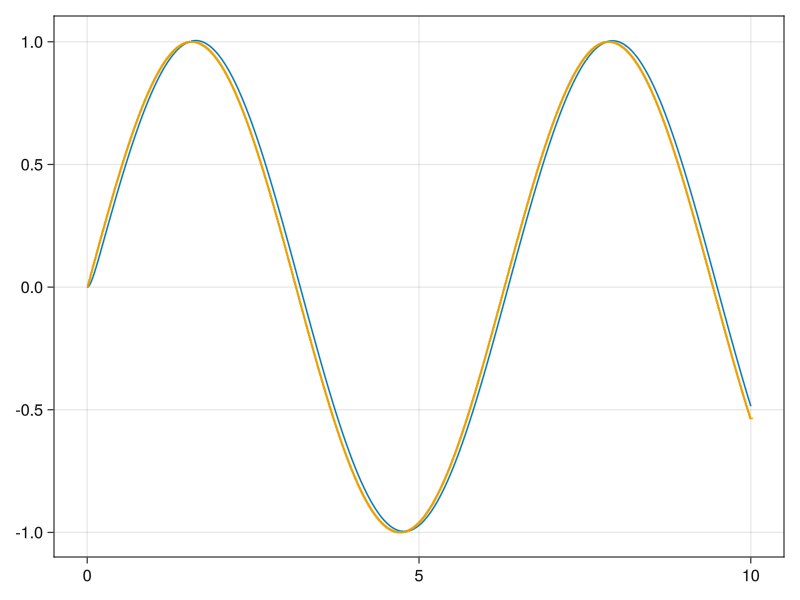

GLMakie.Screen(...)

In [1406]:
fig = Figure()
ax = Axis(fig[1, 1])

lines!(ax, sol.t, sol[plant.y[1]])

#lines!(ax, sol.t, sol[controller.u])
lines!(ax, sol.t, sol[controller.r[1]])

display(fig)